In [154]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
%load_ext tensorboard

In [ ]:
tfp.Do

In [3]:
@tf.function
def foo(x, y):
    return x**y;

In [4]:
def inner_function(x, y, b):
    x = tf.matmul(x, y)
    x = x + b
    return x

# Use the decorator to make `outer_function` a `Function`.
@tf.function
def outer_function(x):
    y = tf.constant([[2.0], [3.0]])
    b = tf.constant(4.0)
    return inner_function(x, y, b)

In [7]:
foo(tf.constant(2), tf.constant(10)).numpy()

1024

In [8]:
outer_function(tf.constant([[1.0, 2.0]])).numpy()

array([[12.]], dtype=float32)

In [7]:
# logdir = './logs/euler'
# writer = tf.summary.create_file_writer(logdir)


In [10]:
x = tf.random.uniform((3, 3))
y = tf.random.uniform((3, 3))
tf.summary.trace_on(graph=True, profiler=True)
z = foo(x, y)
with writer.as_default():
    tf.summary.trace_export(
      name="my_func_trace",
      step=0,
      profiler_outdir=logdir)

Instructions for updating:
use `tf.profiler.experimental.start` instead.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.


In [11]:
%load_ext tensorboard
%tensorboard --logdir ./logs/func

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 5700.

In [169]:
@tf.function
def lotka_voltera(z):
    x, y = tf.split(z, num_or_size_splits=2, axis=0)
    dx = 2/3 * x - 4/3 * y
    dy = x*y - y
    return tf.concat((dx, dy), axis=0)

@tf.function
def lotka_voltera_time(t, z):
    return lotka_voltera(z)

In [7]:
lotka_voltera(tf.constant([0.5, 0.2], dtype=tf.float32))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.06666666, -0.1       ], dtype=float32)>

In [213]:
class EulerMethod:
    def __init__(self):
        self.nfe = 0
        self.t = tf.Variable(0, dtype=tf.float32)
        
    @tf.function
    def __call__(self, func, z0, h, t_end):
        self.t.assign(0)
        z1 = z0
        res = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
        i = 0
        while self.t < t_end:
            res = res.write(i, z0)
            z1 = z0 + h * func(z0)
            self.t.assign_add(h)
            z0 = z1
            i = i + 1
        self.nfe = i
        return z0

class DorpiWrapper:
    def __init__(self):
        self.dorpi = tfp.math.ode.DormandPrince()
        self.nfe = 0
    
    @tf.function
    def __call__(self, func, z0, h, t_end):
        self.nfe = 0
        def skip_time(t, z):
            return func(z)
        
        res = self.dorpi.solve(skip_time, 0, z0, [t_end])
        self.nfe = res[2].num_ode_fn_evaluations
        return res[1][0]
        

In [206]:
dorpi = tfp.math.ode.DormandPrince()
res = dorpi.solve(lotka_voltera_time, 0, tf.constant([0.5, 0.2], dtype=tf.float32), [1])

In [212]:
res[2].num_ode_fn_evaluations

24

In [196]:
dorpi = DorpiWrapper()
dorpi(lotka_voltera, tf.constant([0.5, 0.2], dtype=tf.float32), 0, 1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.66315323, 0.12941906], dtype=float32)>

In [13]:
# euler_method(lotka_voltera, tf.constant([0.5, 0.2], dtype=tf.float32), 
#                    tf.constant(0.001, dtype=tf.float32), tf.constant(3, dtype=tf.float32))
ode = EulerMethod()

In [14]:
ode(lotka_voltera, tf.constant([0.5, 0.2], dtype=tf.float32), tf.constant(0.001, dtype=tf.float32), tf.constant(3, dtype=tf.float32))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.8459357 , 0.16821778], dtype=float32)>

In [24]:
g = euler_method.get_concrete_function(lotka_voltera, tf.constant([0.5, 0.2], dtype=tf.float32), 
                   tf.constant(0.001, dtype=tf.float32), tf.constant(3, dtype=tf.float32)).graph

In [25]:
f = open("grpah.pbtxt", "w")
f.write(str(g.as_graph_def()))
f.close()

'node {\n  name: "z0"\n  op: "Placeholder"\n  attr {\n    key: "_user_specified_name"\n    value {\n      s: "z0"\n    }\n  }\n  attr {\n    key: "dtype"\n    value {\n      type: DT_FLOAT\n    }\n  }\n  attr {\n    key: "shape"\n    value {\n      shape {\n        dim {\n          size: 2\n        }\n      }\n    }\n  }\n}\nnode {\n  name: "h"\n  op: "Placeholder"\n  attr {\n    key: "_user_specified_name"\n    value {\n      s: "h"\n    }\n  }\n  attr {\n    key: "dtype"\n    value {\n      type: DT_FLOAT\n    }\n  }\n  attr {\n    key: "shape"\n    value {\n      shape {\n      }\n    }\n  }\n}\nnode {\n  name: "t_end"\n  op: "Placeholder"\n  attr {\n    key: "_user_specified_name"\n    value {\n      s: "t_end"\n    }\n  }\n  attr {\n    key: "dtype"\n    value {\n      type: DT_FLOAT\n    }\n  }\n  attr {\n    key: "shape"\n    value {\n      shape {\n      }\n    }\n  }\n}\nnode {\n  name: "Const"\n  op: "Const"\n  attr {\n    key: "dtype"\n    value {\n      type: DT_FLOAT\n    

In [13]:
start = tf.Variable([0.5, 0.2], dtype=tf.float32)
with tf.GradientTape() as tape:
    res = euler_method(lotka_voltera, start, 
                   tf.constant(0.001, dtype=tf.float32), tf.constant(3, dtype=tf.float32))
tape.gradient(res[0], start)

0


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 5.789681, -7.625455], dtype=float32)>

In [28]:
res.write(0, lotka_voltera(tf.([0.5, 0.2], dtype=tf.float32)))

In [5]:
logdir = './logs3/euler'
writer = tf.summary.create_file_writer(logdir)
tf.summary.trace_on(graph=True, profiler=True)
z = euler_method(lotka_voltera, tf.constant([0.5, 0.2], dtype=tf.float32), 
             tf.constant(0.001, dtype=tf.float32), tf.constant(3, dtype=tf.float32))
with writer.as_default():
    tf.summary.trace_export(
      name="trace_euler_method",
      step=0,
      profiler_outdir=logdir)

Instructions for updating:
use `tf.profiler.experimental.start` instead.
0
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.


In [145]:
class NeuralODEBlock(keras.layers.Layer):
    def __init__(self, odesolver, odefunc, **kwargs):
        super().__init__(kwargs)
        self.odesolver = odesolver
        self.odefunc = odefunc
        self.h = tf.constant(0.01, dtype=tf.float32)
        self.t = tf.constant(1, dtype=tf.float32)
    
    def build(self, input_shape):
        self.trainable = True
        
    def call(self, inputs):
        return self.odesolver(self.odefunc, inputs, self.h, self.t)
    

In [14]:
@tf.function
def linear(inputs):
    return inputs

In [197]:
class MyDense(keras.layers.Layer):
    def __init__(self, num_units, activation, **kwargs):
        super().__init__(kwargs)
        self.nunits = num_units;
        self.activation = activation
    
    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(w_init(shape=(input_shape[1], self.nunits)), trainable=True)
        self.b = tf.Variable(w_init(shape=(1, self.nunits)), trainable=True)
        self.trainable = True
        #print("builded!")
    
    def call(self, inputs):
        #tf.print("call")
        return self.activation( tf.add(tf.matmul(inputs, self.w), self.b))

In [231]:
i = keras.layers.Input(64)
o = MyDense(64, tf.nn.relu)(i)
o = MyDense(64, tf.nn.relu)(o)
odefunc = keras.Model(inputs=i, outputs=o)
#odefunc.build((10,))

In [232]:
euler = DorpiWrapper()
i = keras.layers.Input(2)
o = MyDense(64, linear)(i)
o = NeuralODEBlock(euler, odefunc)(o)
o = MyDense(2, linear)(o)

In [233]:
m = keras.Model(inputs=i, outputs=o)

In [234]:
@tf.function
def NFE(y_true, y_pred):
    return euler.nfe
m.compile("Adam", "mse")

In [235]:
m.summary()

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
my_dense_101 (MyDense)       (None, 64)                192       
_________________________________________________________________
neural_ode_block_25 (NeuralO (None, 64)                8320      
_________________________________________________________________
my_dense_102 (MyDense)       (None, 2)                 130       
Total params: 8,642
Trainable params: 8,642
Non-trainable params: 0
_________________________________________________________________


In [239]:
print(m.predict([[0.5, 0.1]]))
euler.nfe

[[-0.03078763 -0.03832766]]


<tf.Tensor 'IdentityN:2' shape=() dtype=int32>

In [77]:
import sys
import os
sys.path.append(os.getcwd() + "\\..\\")
import main

In [78]:
X, Y, X_test, Y_test, max_train, max_test = main.make_data()

In [240]:
h = m.fit(X, Y, batch_size=32, epochs=100)

Epoch 1/100
939/939 [==============================] - 9s 7ms/step - loss: 0.0046
Epoch 2/100
939/939 [==============================] - 7s 8ms/step - loss: 2.6275e-06
Epoch 3/100
939/939 [==============================] - 7s 7ms/step - loss: 2.8858e-06
Epoch 4/100
939/939 [==============================] - 6s 7ms/step - loss: 3.4859e-06
Epoch 5/100
939/939 [==============================] - 7s 7ms/step - loss: 1.2917e-06
Epoch 6/100
939/939 [==============================] - 7s 7ms/step - loss: 1.1916e-06
Epoch 7/100
939/939 [==============================] - 6s 7ms/step - loss: 3.1303e-06
Epoch 8/100
939/939 [==============================] - 6s 7ms/step - loss: 2.3132e-06
Epoch 9/100
939/939 [==============================] - 6s 6ms/step - loss: 3.5500e-06
Epoch 10/100
939/939 [==============================] - 6s 6ms/step - loss: 1.3573e-06
Epoch 11/100
939/939 [==============================] - 6s 7ms/step - loss: 7.0665e-07
Epoch 12/100
939/939 [==============================] - 

In [135]:
from cycler import cycler
import model
from scipy import integrate
# color_c = cycler('color', ['k'])
# style_c = cycler('linestyle', ['-', '--', ':', '-.'])
# markr_c = cycler('marker', ['', '.', 'o'])
# c_cms = color_c * markr_c * style_c
# c_csm = color_c * style_c * markr_c

def model_predict(m, start, norm_value,  steps):
    """Приминение модели для получения предстказания траектории"""
    mbegin =np.array([start]) / norm_value;
    predict = [np.array(mbegin)]
    for i in range(steps-1):
        predict.append(m.predict(predict[-1]))
    return np.stack(predict).reshape(-1, 2)

def make_plots(predict_data, model_data):
    """Формирование графиков на основе данных"""
    if len(predict_data) != len(model_data):
        raise RuntimeError("lenthg of predict_data and model_data must be equal")
    fg = plt.figure(dpi=1000, figsize=(9, 4), constrained_layout=True)
    gs = fg.add_gridspec(2, 6)
    time_sequence = [i for i in range(len(predict_data))]
    
    ax = fg.add_subplot(gs[0, 0:2])
    ax.scatter(time_sequence, predict_data[:, 0], 
                     label="Предсказание", c="b",
                     alpha = 0.5)
    ax.scatter(time_sequence, model_data[:, 0], label="Решение", c='r', alpha = 0.5)
    #ax.legend(bbox_to_anchor=(1.05,1.0),loc='best')
    ax.set_xlabel('Время')
    ax.set_title("Популяция жертв")
    
    ax = fg.add_subplot(gs[0, 2:4])
    ax.scatter(time_sequence, predict_data[:, 1], label="predict", c="b", alpha = 0.5)
    ax.scatter(time_sequence, model_data[:, 1], label="solve", c='r', alpha = 0.5)
    #ax.legend()
    ax.set_xlabel('Время')
    ax.set_title("Популяция хищников")
    
    ax = fg.add_subplot(gs[0, 4:6])
    sc = ax.scatter(predict_data[:, 0], predict_data[:, 1], alpha = 0.5, cmap='viridis', c=time_sequence)
    fg.colorbar(sc, ax=ax)
    ax.plot(model_data[:, 0], model_data[:, 1], linewidth=2.5, c="r")
    ax.set_xlabel('Жертва')
    ax.set_ylabel('Хищник')
    ax.set_title("Фазовый портрет")
    
    ax = fg.add_subplot(gs[1, 0:3])
    ax.plot(time_sequence, predict_data[:, 0] - model_data[:, 0], label="Хищник", linewidth=2.5)
    ax.plot(time_sequence, predict_data[:, 1] - model_data[:, 1], label="Жертва", linewidth=2.5)
    ax.set_title("Разность между решением и предсказанием")
    ax.legend()
    ax.set_xlabel('Время')
    
    ax = fg.add_subplot(gs[1, 3:6])
    ax.plot(time_sequence, (predict_data[:, 0] - model_data[:, 0])/model_data[:, 0],
                     label="Хищник", linewidth=2.5)
    ax.plot(time_sequence, (predict_data[:, 1] - model_data[:, 1])/model_data[:, 1],
                     label="Жертва", linewidth=2.5)
    ax.set_title("Значение метрики RAE")
    ax.legend()
    ax.set_xlabel('Время')
    
   
    
def model_predict_test(ann_model,
                       analitic_model,
                       start,
                       norm_value,
                       steps,
                       time_end):
    predict = model_predict(ann_model, start, norm_value,  steps)
    time_sequence = np.linspace(0, time_end, steps)
    solve = integrate.odeint(analitic_model, start , time_sequence)
    solve = solve/norm_value
    make_plots(predict, solve)

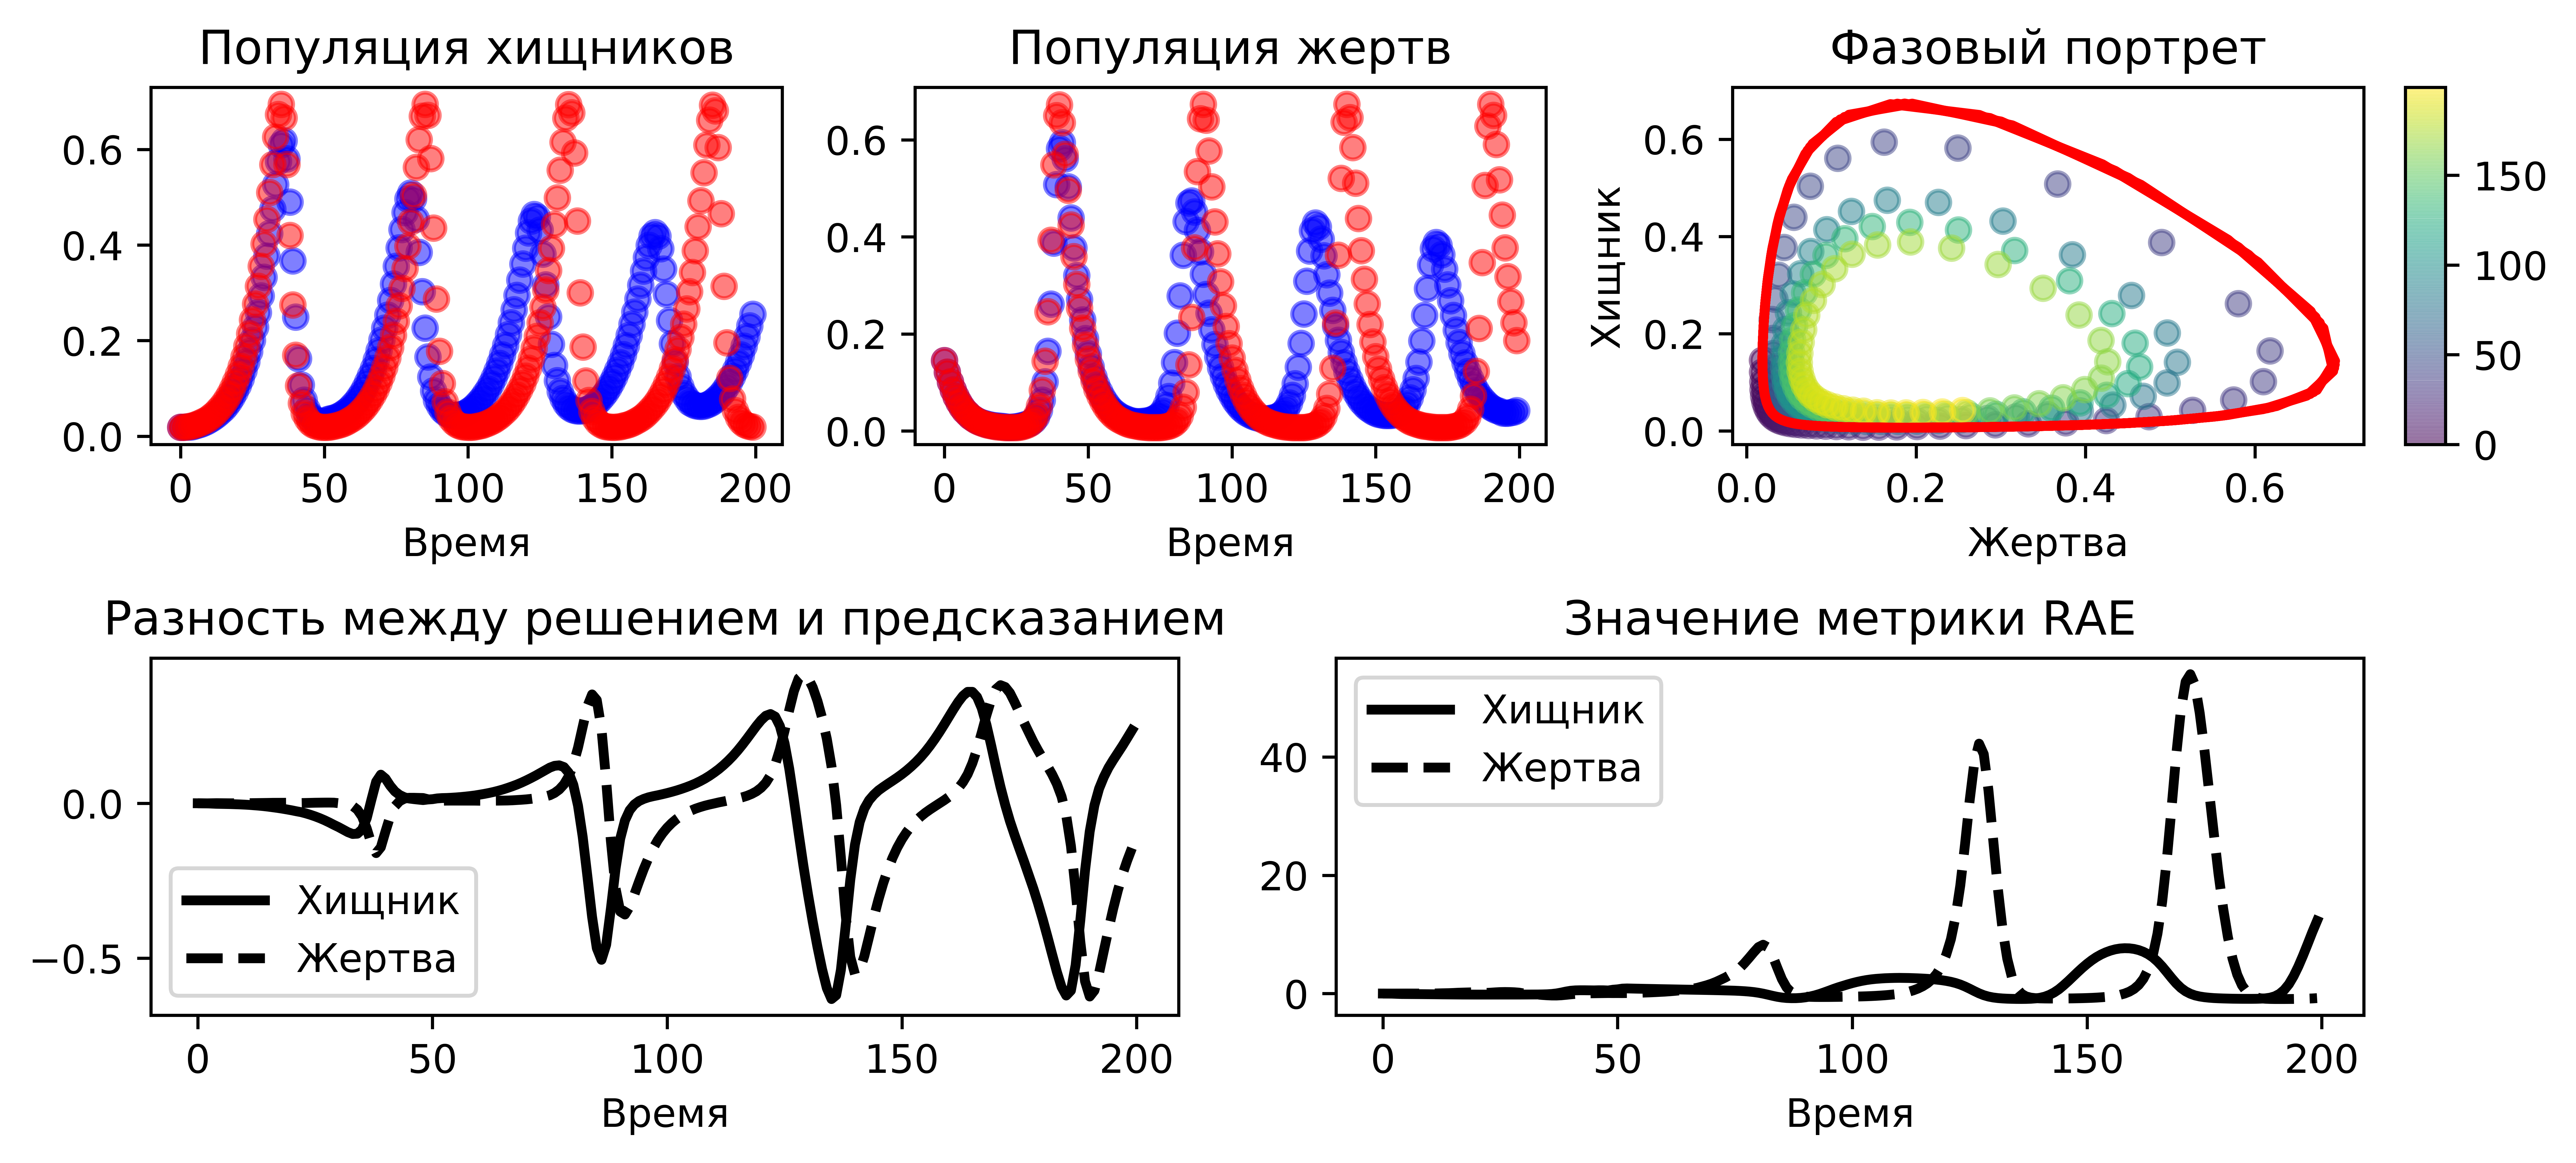

In [243]:
#plt.rc('axes', prop_cycle=c_cms)
lotka_voltera = model.LotkaVoltera(2/3, 4/3, 1, 1, [])
model_predict_test(m, lotka_voltera, [0.1, 0.5], max_train, 200, 40)
#[0.8, 0.1]

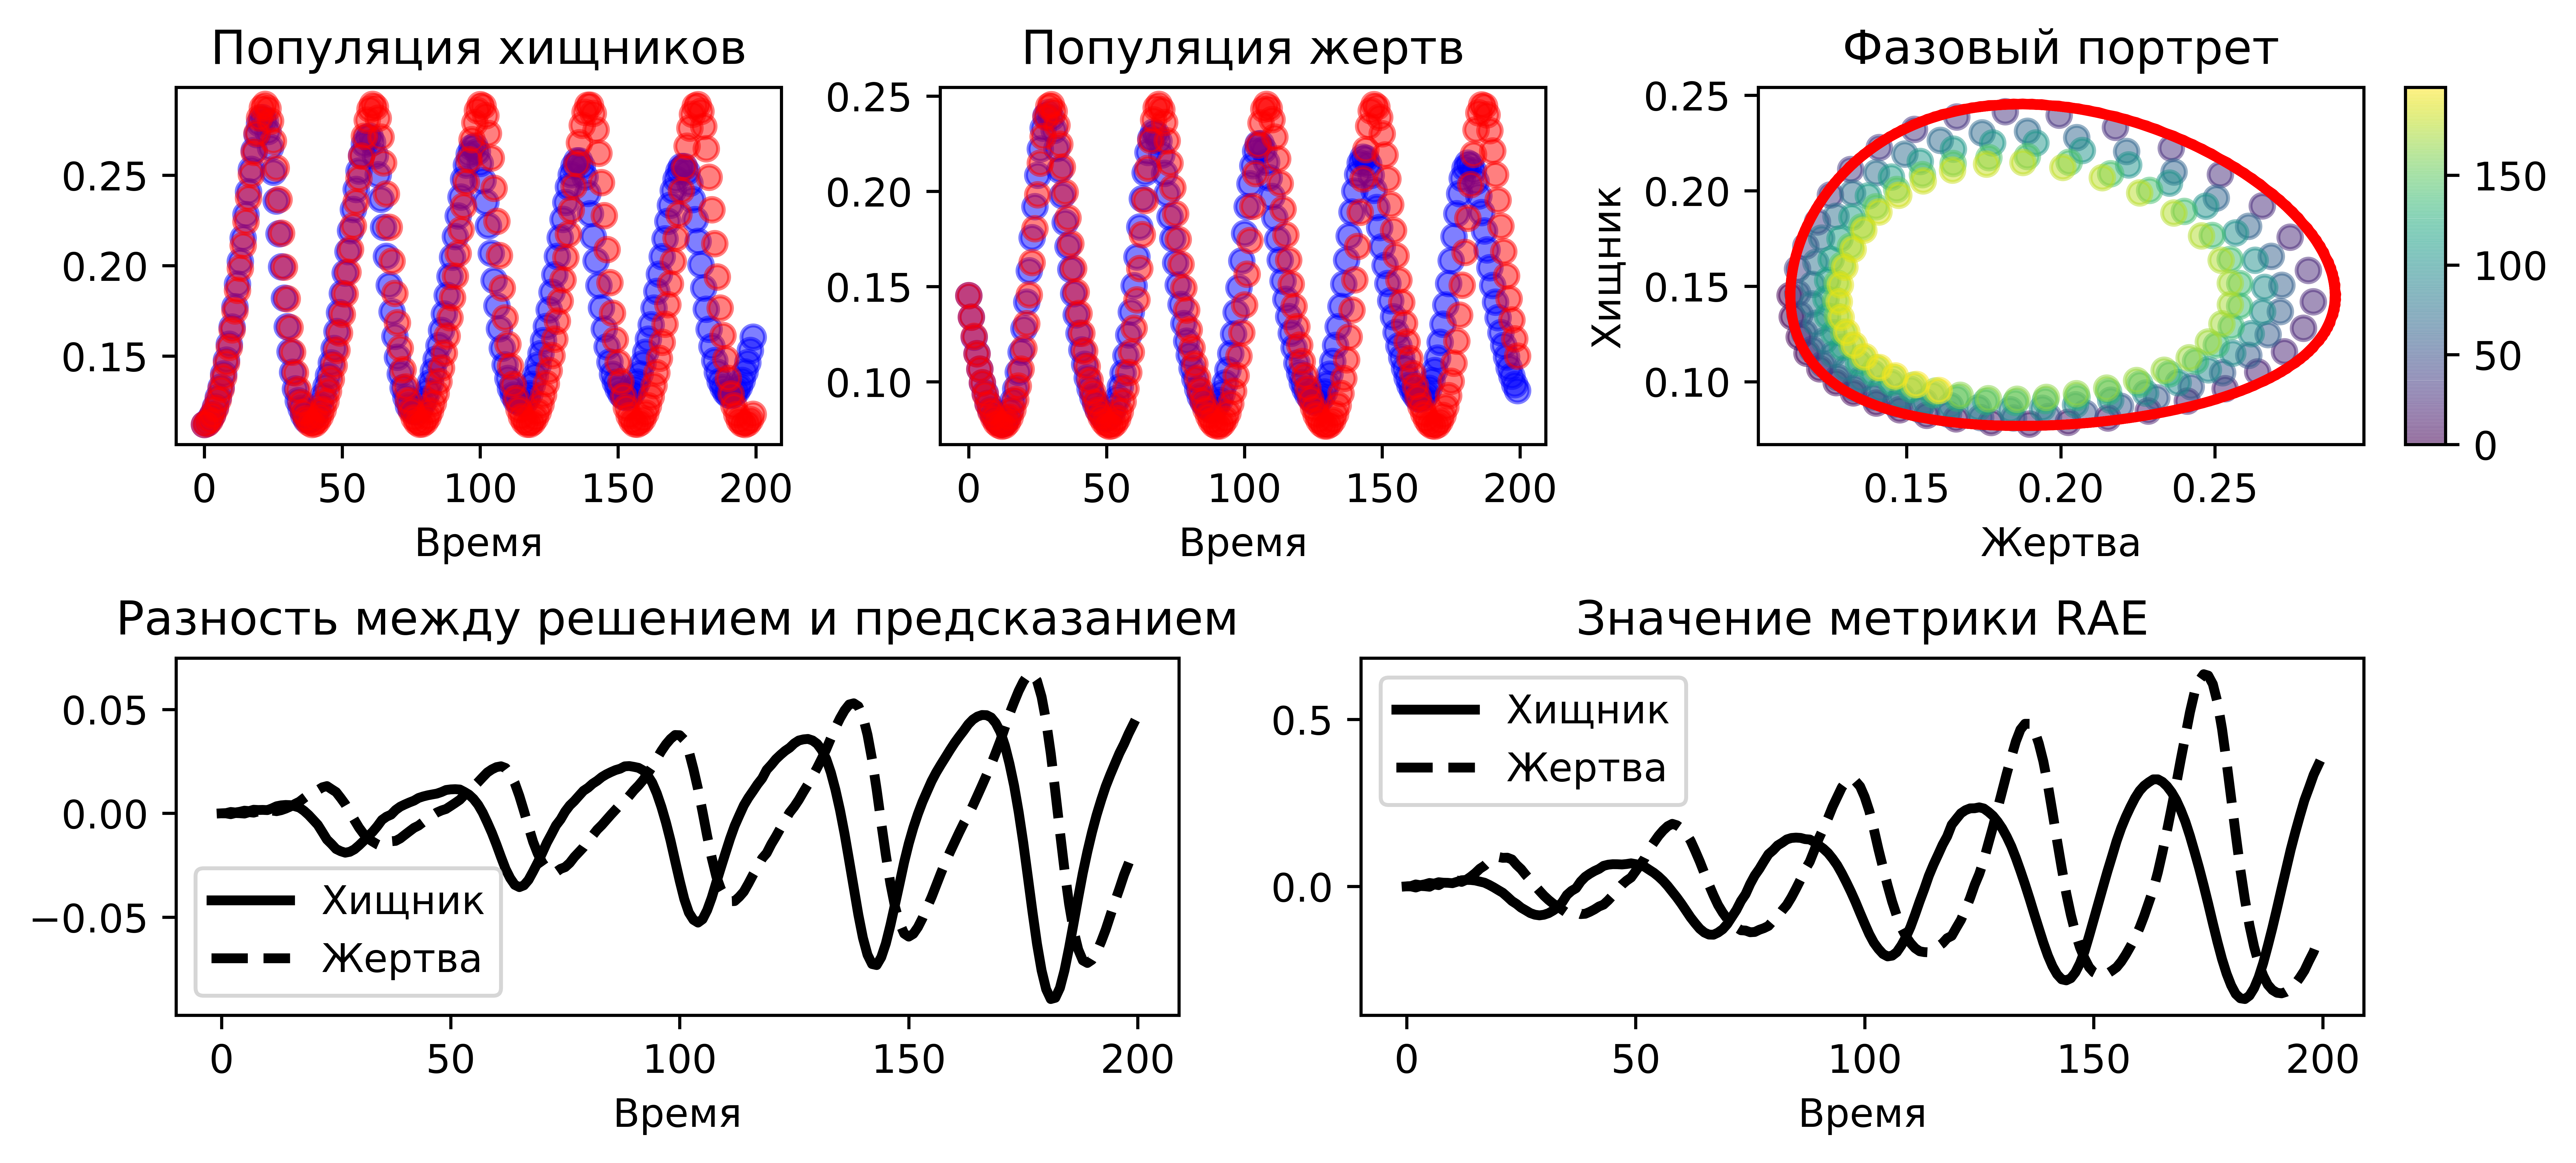

In [246]:
lotka_voltera = model.LotkaVoltera(2/3, 4/3, 1, 1, [])
model_predict_test(m, lotka_voltera, [0.6, 0.5], max_train, 200, 40)